# Facial keypoints detection


## Import modules

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

## Gloabal variables

In [2]:
img_size = 48
bsize=16
n_epochs=50
n_take=5

## Get info and visualize data

In [3]:
load_dir = './'
df_train = pd.read_csv(load_dir + 'train.csv')

In [4]:
train_paths = load_dir + 'train/' + df_train["filename"].values
train_keypoints = df_train.drop(["filename"], axis=1).values
print(train_paths)

['./train/05317.jpg' './train/04767.jpg' './train/05241.jpg' ...
 './train/05226.jpg' './train/05390.jpg' './train/00860.jpg']


In [5]:
test_paths = os.listdir(load_dir + "test")

print(f"Train data size: {train_paths.shape[0]}")
print(f"Test data size: {len(test_paths)}")

Train data size: 5000
Test data size: 1000


In [6]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image, cmap='gray')
    plt.scatter(key_pts[::2], key_pts[1::2], s=100, marker='.', c='m')

visualize keypoints on image

[ 25  55  63  39 145  36 171  45  39  74  61  69  79  72 130  68 145  65
 159  65 113 103  79 148 113 148 143 141]


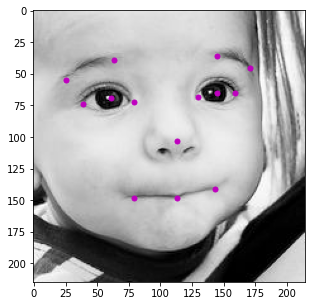

In [7]:
n = 0
image_path = train_paths[n]
key_pts = train_keypoints[n]

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(image_path), key_pts)
print(key_pts)
plt.show()

## Transforms

In [8]:
def concat_x_y(x_keypoints, y_keypoints):
    '''Utility function, solve problem assign on tensor elements'''
    T = tf.transpose
    keypoints = tf.reshape(T(tf.stack([T(x_keypoints), T(y_keypoints)], axis=0)), [-1, tf.shape(x_keypoints)[0]])
    return tf.concat([keypoints[0], keypoints[1]], 0)

def normalize(image):
    '''Normalized image'''
    # scale color range from [0, 255] to [0, 1]
    image_normalized = tf.cast(image, tf.float32) / 255.0
    
    return image_normalized

def rescale(image, output_size, keypoints=None):  
    '''resize image and keypoints to  output size '''
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    
    new_height, new_width = output_size
    
    image = tf.image.resize(image, output_size)
    
    image = tf.reshape(image, (new_height, new_width, 1))
    
    if keypoints is None:
        return image
    
    #scale the keypoints
    keypoints = tf.cast(keypoints, tf.float32)
    x_keypoints = keypoints[::2] * (float(new_width) / float(width))
    y_keypoints = keypoints[1::2] * (float(new_height) / float(height))
    return image, tf.cast(concat_x_y(x_keypoints, y_keypoints), tf.int32)

## Image decoder

In [9]:
def build_decoder(with_labels=True, out_size=(img_size, img_size)):
    def get_image_with_extension(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels=1)    
        return img
    
    def decode(path):
        img = get_image_with_extension(path)
        img = rescale(img, out_size)
        img = normalize(img) 
        return img

    def decode_with_labels(path, label):
        img = get_image_with_extension(path)
        img, label = rescale(img, out_size, keypoints=label)
        img = normalize(img)
        return img, label
    
    return decode_with_labels if with_labels else decode 

## Data augmentation 

In [10]:
angle=12

In [11]:
def left_right_flip_augmentation(image, keypoints):
    image = tf.image.flip_left_right(image)
    x_keypoints = img_size - keypoints[::2]
    y_keypoints = keypoints[1::2]
    return image, concat_x_y(x_keypoints, y_keypoints)

def rotation_augmentation(image, keypoints):
    M = cv2.getRotationMatrix2D((img_size/2, img_size/2), angle, 1.0)
    angle_rad = -angle * pi/180.     
    image = cv2.warpAffine(image, M, (img_size, img_size), flags=cv2.INTER_CUBIC)
               
    keypoints = keypoints - img_size/2
    x_keypoint = keypoints[::2] * tf.math.cos(angle_rad) - keypoints[1::2] * tf.math.sin(angle_rad)
    y_keypoint = keypoints[1::2] * tf.math.sin(angle_rad) + keypoints[1::2] * tf.math.cos(angle_rad)
    keypoint = concat_x_y(x_keypoints, y_keypoints) + img_size/2
    return image, keypoints
            
def increased_brightness_augmentation(image, keypoints):
    return tf.clip_by_value(image*1.2, 0.0, 1.0), keypoints

def decreased_brightness_augmentation(image, keypoints):
    return tf.clip_by_value(image*0.6, 0.0, 1.0), keypoints

def add_random_noise_augmentation(image, keypoints):
    return tf.add(image, 0.008*np.random.randn(img_size, img_size ,1)), keypoints

## Dataset function 

In [12]:
def build_dataset(paths, labels=None, cache=False, decoder=None, augment=False, shuffle=1024, bsize=1, cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    if decoder is None:
        decoder = build_decoder(labels is not None)        
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decoder, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    if augment:
        dset_left_right_flip_augmentation = dset.map(left_right_flip_augmentation, num_parallel_calls=AUTO)
        #dset_rotation_augmentation = dset.map(rotation_augmentation)
        dset_increased_brightness_augmentation = dset.map(increased_brightness_augmentation, num_parallel_calls=AUTO)
        dset_decreased_brightness_augmentation = dset.map(decreased_brightness_augmentation, num_parallel_calls=AUTO)
        dset_add_random_noise_augmentation = dset.map(add_random_noise_augmentation, num_parallel_calls=AUTO)
        
        dset = dset.concatenate(dset_left_right_flip_augmentation)
        #dset = dset.concatinate(dset_rotation_augmentation)
        dset = dset.concatenate(dset_increased_brightness_augmentation)
        dset = dset.concatenate(dset_decreased_brightness_augmentation)
        dset = dset.concatenate(dset_add_random_noise_augmentation)
        
    dset = dset.shuffle(shuffle)
    dset = dset.batch(bsize)
    dset = dset.prefetch(buffer_size=AUTO)
    return dset
    

## Load dataset 

In [13]:
train_paths, validation_paths, train_keypoints, validation_keypoints = train_test_split(train_paths, train_keypoints, test_size=0.05, shuffle=True)

dtrain = build_dataset(train_paths, train_keypoints, augment=True, bsize=bsize)

dvalid = build_dataset(validation_paths, validation_keypoints, bsize=bsize)

tf.Tensor(
[12  8 19 11 28 10 40 12 14 13 16 13 19 14 30 16 34 16 38 17 22 26 17 32
 20 33 27 34], shape=(28,), dtype=int32)


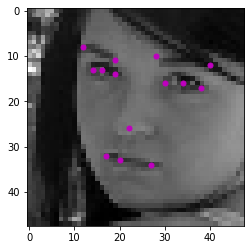

In [14]:
plt.figure(figsize=(4,4))
for n, (image, label) in enumerate(dtrain.take(1)):
    show_keypoints(tf.squeeze(image[0]), label[0])
    print(label[0])
    plt.show()

## Create model

### Imort keras

In [15]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, MaxPooling2D,Flatten, Dense, Dropout

### Model architecture

In [16]:
class FacialKeypointDetection(Model):
    def __init__(self, input_shape=(img_size, img_size, 1), num_output=28):
        super(FacialKeypointDetection, self).__init__()
        self.input_layer = Input(shape=input_shape)
        self.block1_conv1 = Conv2D(32, (3,3), padding='same')
        self.blocl1_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block1_batchNorm = BatchNormalization()
        
        self.block2_conv1 = Conv2D(32, (3,3), padding='same')
        self.block2_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block2_batchNorm= BatchNormalization()
        self.block2_max_pool1 = MaxPool2D(pool_size=(2, 2))
        self.block2_drop = Dropout(0.1)

        self.block3_conv1 = Conv2D(64, (3,3), padding='same')
        self.blocl3_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block3_batchNorm = BatchNormalization()

        self.block4_conv1 = Conv2D(64, (3,3), padding='same')
        self.block4_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block4_batchNorm = BatchNormalization()
        self.block4_max_pool1 = MaxPool2D(pool_size=(2, 2))
        self.block4_drop = Dropout(0.1)

        self.block5_conv1 = Conv2D(96, (3,3), padding='same')
        self.blocl5_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block5_batchNorm = BatchNormalization()

        self.block6_conv1 = Conv2D(96, (3,3), padding='same')
        self.block6_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block6_batchNorm = BatchNormalization()
        self.block6_max_pool1 = MaxPool2D(pool_size=(2, 2))
        self.block6_drop = Dropout(0.1)

        self.block7_conv1 = Conv2D(128, (3,3), padding='same')
        self.blocl7_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block7_batchNorm = BatchNormalization()

        self.block8_conv1 = Conv2D(128, (3,3), padding='same')
        self.block8_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block8_batchNorm = BatchNormalization()
        self.block8_max_pool1 = MaxPool2D(pool_size=(2, 2))
        self.block8_drop = Dropout(0.1)
    
        self.block9_conv1 = Conv2D(256, (3,3), padding='same')
        self.blocl9_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block9_batchNorm = BatchNormalization()

        self.block10_conv1 = Conv2D(512, (3,3), padding='same')
        self.blocl10_leakyReLU1 = LeakyReLU(alpha = 0.1)
        self.block10_batchNorm = BatchNormalization()
        
        self.flatten = Flatten()
        self.dense1 = Dense(512,activation='relu')
        self.dropout = Dropout(0.1)
        self.dense2 = Dense(num_output)
        self.out = self.call(self.input_layer)
        
    def call(self, input):
        x = self.block1_conv1(input)
        x = self.blocl1_leakyReLU1(x)
        x = self.block1_batchNorm(x)

        x = self.block2_conv1(x)
        x = self.block2_leakyReLU1(x)
        x = self.block2_batchNorm(x)
        x = self.block2_max_pool1(x)
        x = self.block2_drop(x)
        
        x = self.block3_conv1(x)
        x = self.blocl3_leakyReLU1(x)
        x = self.block3_batchNorm(x)

        x = self.block4_conv1(x)
        x = self.block4_leakyReLU1(x)
        x = self.block4_batchNorm(x)
        x = self.block4_max_pool1(x)
        x = self.block4_drop(x)

        x = self.block5_conv1(x)
        x = self.blocl5_leakyReLU1(x)
        x = self.block5_batchNorm(x)

        x = self.block6_conv1(x)
        x = self.block6_leakyReLU1(x)
        x = self.block6_batchNorm(x)
        x = self.block6_max_pool1(x)
        x = self.block6_drop(x)
        
        x = self.block7_conv1(x)
        x = self.blocl7_leakyReLU1(x)
        x = self.block7_batchNorm(x)

        x = self.block8_conv1(x)
        x = self.block8_leakyReLU1(x)
        x = self.block8_batchNorm(x)
        x = self.block8_max_pool1(x)
        x = self.block8_drop(x)
        
        x = self.block9_conv1(x)
        x = self.blocl9_leakyReLU1(x)
        x = self.block9_batchNorm(x)
        
        x = self.block10_conv1(x)
        x = self.blocl10_leakyReLU1(x)
        x = self.block10_batchNorm(x)
        
        x = self.flatten(x) 
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)


In [17]:
model = FacialKeypointDetection()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'acc'])
model.build(input_shape=(None, img_size, img_size, 1))
print(model.summary())

Model: "facial_keypoint_detection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 2

### Train model

In [18]:
#if os.path.isfile("./best_weights.h5"):
#    model.load_weights('./best_weights.h5')
    
#checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True)

#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_lr=0.00001)

history = model.fit(dtrain,
                    validation_data=dvalid,
                    epochs=n_epochs,
#                    callbacks=[checkpoint, lr_reduce],
                    verbose=True,
                    shuffle=True)


Epoch 1/50
1485/1485 [==============================] - 320s 214ms/step - loss: 22.5706 - mae: 3.0199 - acc: 0.5338 - val_loss: 3.5847 - val_mae: 1.2532 - val_acc: 0.8760
Epoch 2/50
1485/1485 [==============================] - 276s 186ms/step - loss: 12.3208 - mae: 2.1487 - acc: 0.6914 - val_loss: 3.0977 - val_mae: 1.2830 - val_acc: 0.8520
Epoch 3/50
1485/1485 [==============================] - 314s 211ms/step - loss: 11.2648 - mae: 2.0128 - acc: 0.7209 - val_loss: 2.2572 - val_mae: 1.0401 - val_acc: 0.8480
Epoch 4/50
1485/1485 [==============================] - 284s 191ms/step - loss: 10.8127 - mae: 1.9499 - acc: 0.7350 - val_loss: 2.1408 - val_mae: 1.1180 - val_acc: 0.8520
Epoch 5/50
1485/1485 [==============================] - 253s 170ms/step - loss: 10.7536 - mae: 1.9338 - acc: 0.7334 - val_loss: 1.9720 - val_mae: 1.0021 - val_acc: 0.8600
Epoch 6/50
1485/1485 [==============================] - 260s 175ms/step - loss: 10.8947 - mae: 1.9344 - acc: 0.7300 - val_loss: 1.8024 - val_mae:

Epoch 49/50
1485/1485 [==============================] - 394s 265ms/step - loss: 3.4714 - mae: 1.2021 - acc: 0.8629 - val_loss: 1.8770 - val_mae: 0.9430 - val_acc: 0.8440
Epoch 50/50
1485/1485 [==============================] - 395s 266ms/step - loss: 3.4519 - mae: 1.1977 - acc: 0.8649 - val_loss: 1.5308 - val_mae: 0.8868 - val_acc: 0.8480


### Ploting graphs

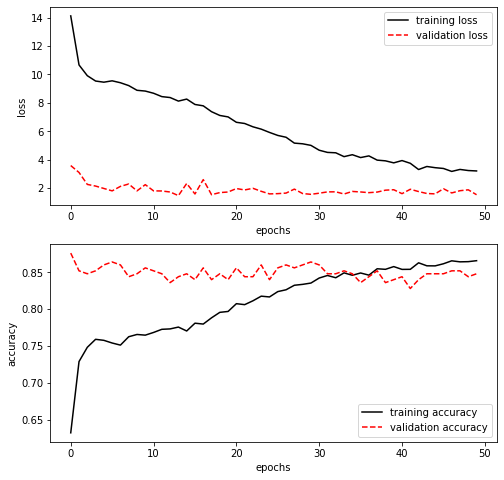

In [19]:
model.save_weights("best_weights.h5")

hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(8,8),nrows=2, ncols=1)

hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend()

hist['acc'].plot(ax=ax2, c='k', label='training accuracy')
hist['val_acc'].plot(ax=ax2, c='r', linestyle='--', label='validation accuracy')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.show()

### Visualize the predicted keypoints

[ 8.609245 10.630493 18.891335 11.196816 28.533106 11.447802 37.714363
 10.727254 11.332691 13.056146 15.028023 12.949604 18.349628 13.714055
 28.696606 13.909534 32.232845 13.062977 35.53793  13.32995  23.503681
 26.211988 16.235207 30.92     23.459572 32.647663 30.366863 30.835335]


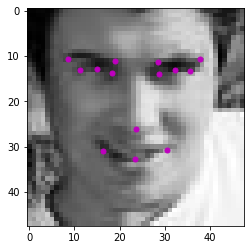

[15.879332   4.7234936 25.414764   9.849642  34.42334   14.638765
 43.5104    17.801027  16.428648   9.439487  19.961025  11.155339
 22.962578  13.235561  32.879692  18.23741   36.312004  18.994843
 39.60317   20.598036  22.744684  27.216326  13.284912  28.688538
 19.59148   33.63467   27.389488  34.522114 ]


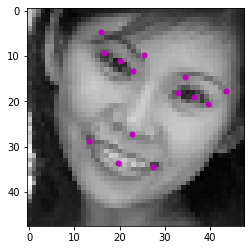

[11.687115   8.126513  19.952492   9.585578  29.737684  11.23311
 39.690075  12.852308  13.391314  12.315594  16.770092  12.787602
 19.595211  13.656335  30.474888  15.605022  34.002712  15.6509285
 37.43062   16.430038  21.244764  24.872412  15.610117  30.518948
 21.940588  32.862156  30.61222   32.550716 ]


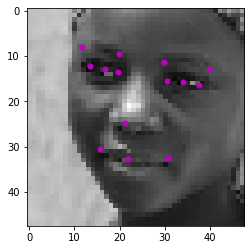

[ 9.106716  10.187507  19.431467  10.263105  29.30581   10.810439
 38.729492  11.192235  11.515935  13.413659  15.283148  13.272132
 18.572924  13.933958  29.481781  14.439051  33.08154   13.9267235
 36.3846    14.395851  23.212797  24.95004   15.554775  32.056538
 22.731869  33.202595  29.901115  32.427372 ]


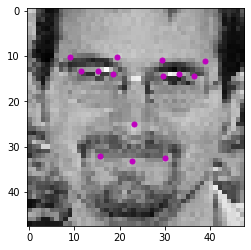

[ 7.2307887 11.258119  17.968996  11.84247   28.006037  11.418424
 37.31521    9.182526  10.418998  14.228002  14.475981  14.055469
 17.92646   14.734576  28.27063   14.200418  31.921444  12.938869
 35.413593  12.818726  24.372152  27.283606  17.481121  31.64641
 24.587608  33.007153  30.981983  30.610367 ]


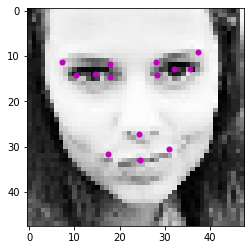

In [42]:
test_dir = "./test/"
filenames = os.listdir(test_dir)
test_paths = [test_dir + f for f in filenames] 
dtest = build_dataset(test_paths, shuffle=1, bsize=1)
predictions = model.predict(dtest)

plt.figure(figsize=(4,4))
for n, image in enumerate(dtest.take(n_take)):
    show_keypoints(tf.reshape(image, (img_size, img_size)), predictions[n])
    print(predictions[n])
    plt.show()


### Save results in file

In [39]:
def rescale_with_path(path, keypoints, size):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(file_bytes, channels=1)  
    
    new_height, new_width = tf.shape(img)[0], tf.shape(img)[1] 
    height, width = size

    keypoints[::2]= keypoints[::2] * (float(new_width) / float(width))
    keypoints[1::2]= keypoints[1::2] * (float(new_height) / float(height))
    return keypoints
    
def recovery_keypoints_size(test_paths, keypoints, img_size):
    for n, path in enumerate(test_paths):
        keypoints[n] = rescale_with_path(path, keypoints[n], img_size)
    return keypoints

def create_submission(test_filenames, predictions, template_dataframe):
    #extract columns names in train.csv
    columns = [x for x in template_dataframe.columns]
               
    test_filenames = np.array(test_filenames, ndmin=2).T
    data = np.append(test_filenames, predictions, axis=1)
    df_submission = pd.DataFrame(data=data, columns=columns)
    return df_submission

In [40]:
predictions = tf.squeeze(predictions).numpy()

# recovery size keypoints by real image size
predictions = recovery_keypoints_size(test_paths, predictions, (img_size, img_size)).astype("int32")
print(predictions[:n_take])

[[  8  10  18  10  27  11  36  10  11  12  14  12  17  13  28  13  31  12
   34  13  23  25  15  30  22  31  29  30]
 [ 39  11  63  24  85  36 107  44  40  23  49  27  56  32  81  45  90  47
   98  51  56  67  32  71  48  83  67  85]
 [ 37  25  63  30  94  35 125  40  42  38  53  40  62  43  96  49 107  49
  118  52  67  78  49  96  69 104  96 103]
 [ 31  35  66  35 100  37 133  38  39  46  52  45  63  47 101  49 113  47
  125  49  79  85  53 110  78 114 102 111]
 [ 24  37  60  39  93  38 125  30  34  47  48  47  60  49  94  47 107  43
  118  42  81  91  58 106  82 110 103 102]]


In [41]:
test_filenames = [os.path.basename(x) for x in test_paths]
df_submission = create_submission(test_filenames, predictions, df_train)
df_submission.to_csv("./test.csv", index=False)